In [1]:
#ignore warnings
import warnings
warnings.filterwarnings("ignore")


#calculations
import numpy as np
import pandas as pd 
from scipy import stats

#dataset
from pydataset import data
import os

#sklearn stuff 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score


#graphing
import matplotlib.pyplot as plt
import seaborn as sns

#acquire and prepare data
import acquire 
import prepare
import wrangle

## step 1: Build out the function that I am using to acquire the Telco data set 

In [2]:
def new_telco_data():
    '''
    This function reads the telco data and turns it into a dataframe.
    '''
    sql_query = """
                select * from customers
                join contract_types using (contract_type_id)
                join internet_service_types using (internet_service_type_id)
                join payment_types using (payment_type_id)
                """
    url = get_db_url('telco_churn')
    # Read in DataFrame from Codeup db.
    df = pd.read_sql(sql_query, url)
    
    return df

In [3]:
def get_telco_data():
    '''
      reads telco data, caches it to a local file if there is not one, and returns a df
    '''
    if os.path.isfile('telco.csv'):
        
        # If there is a csv file read the data.
        df = pd.read_csv('telco.csv', index_col=0)
        
    else:
        
        df = new_telco_data()
        
        # Cache data if there is not a csv file already
        df.to_csv('telco.csv')
        
    return df

In [4]:
# run program to ensure that it runs correctly, no abnormalities found
df = get_telco_data()
df.head()

,payment_type_id,internet_service_type_id,contract_type_id,customer_id,gender,senior_citizen,partner,dependents,tenure,phone_service,...,tech_support,streaming_tv,streaming_movies,paperless_billing,monthly_charges,total_charges,churn,contract_type,internet_service_type,payment_type
0,2,1,2,0002-ORFBO,Female,0,Yes,Yes,9,Yes,...,Yes,Yes,No,Yes,65.6,593.3,No,One year,DSL,Mailed check
1,2,1,1,0003-MKNFE,Male,0,No,No,9,Yes,...,No,No,Yes,No,59.9,542.4,No,Month-to-month,DSL,Mailed check
2,1,2,1,0004-TLHLJ,Male,0,No,No,4,Yes,...,No,No,No,Yes,73.9,280.85,Yes,Month-to-month,Fiber optic,Electronic check
3,1,2,1,0011-IGKFF,Male,1,Yes,No,13,Yes,...,No,Yes,Yes,Yes,98.0,1237.85,Yes,Month-to-month,Fiber optic,Electronic check
4,2,2,1,0013-EXCHZ,Female,1,Yes,No,3,Yes,...,Yes,Yes,No,Yes,83.9,267.4,Yes,Month-to-month,Fiber optic,Mailed check


### - now that the data has been acquired, move to prepare the data

# Step 2: prepare the data

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 24 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   payment_type_id           7043 non-null   int64  
 1   internet_service_type_id  7043 non-null   int64  
 2   contract_type_id          7043 non-null   int64  
 3   customer_id               7043 non-null   object 
 4   gender                    7043 non-null   object 
 5   senior_citizen            7043 non-null   int64  
 6   partner                   7043 non-null   object 
 7   dependents                7043 non-null   object 
 8   tenure                    7043 non-null   int64  
 9   phone_service             7043 non-null   object 
 10  multiple_lines            7043 non-null   object 
 11  online_security           7043 non-null   object 
 12  online_backup             7043 non-null   object 
 13  device_protection         7043 non-null   object 
 14  tech_sup

- we need to drop the columns that aren't necessary or are redundant. 
- fix total charges, make it a float instead of an object. 
- create dummy variables column to more easily deal with the data
- concatenate the dummy variables df to df so that we can work with the data

In [6]:
def prep_telco_data(df):
    #drop columns that aren't necessary 
    
        columns = ['customer_id', 'payment_type_id', 'internet_service_type_id' , 'contract_type_id']
        df.drop(columns, inplace = True, axis = 1)
    
    #fix total charges
    
        df['total_charges'] = df['total_charges'].str.strip()
        df = df[df.total_charges != '']
        df['total_charges'] = df.total_charges.astype(float)
    
    #get dummy variables
        dummy_df = pd.get_dummies(df[['gender', \
                                    'partner', \
                                    'dependents', \
                                    'phone_service', \
                                    'paperless_billing', \
                                    'churn', \
                                    'multiple_lines', \
                                    'online_security', \
                                    'device_protection', \
                                    'tech_support', \
                                    'streaming_tv', \
                                     'streaming_movies', \
                                     'contract_type', \
                                     'internet_service_type', \
                                     'payment_type']], dummy_na=False, \
                                  drop_first=True)
    
        df = pd.concat([df, dummy_df], axis = 1)
        
        return df

In [7]:
# we will now set the df to be the prepared telco df 
df = prep_telco_data(df)

In [8]:
# check to see that the prepare went smoothly and that dummy df was added correctly

df.T

,0,1,2,3,4,5,6,7,8,9,...,7033,7034,7035,7036,7037,7038,7039,7040,7041,7042
gender,Female,Male,Male,Male,Female,Female,Female,Male,Female,Female,...,Male,Male,Female,Female,Female,Female,Male,Male,Male,Male
senior_citizen,0,0,0,1,1,0,1,0,1,0,...,0,1,0,0,0,0,0,0,0,0
partner,Yes,No,No,Yes,Yes,No,Yes,Yes,No,Yes,...,No,Yes,No,No,No,No,Yes,No,Yes,Yes
dependents,Yes,No,No,No,No,Yes,No,No,No,Yes,...,No,Yes,No,No,No,No,No,No,Yes,Yes
tenure,9,9,4,13,3,9,71,63,7,65,...,1,47,7,1,4,13,22,2,67,63
phone_service,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes,...,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes,No
multiple_lines,No,Yes,No,No,No,No,No,Yes,No,Yes,...,No,No,No,No,No,No,Yes,No,No,No phone service
online_security,No,No,No,No,No,No,Yes,Yes,Yes,Yes,...,No internet service,No,No,No,No internet service,Yes,No,No,Yes,Yes
online_backup,Yes,No,No,Yes,No,No,Yes,No,No,Yes,...,No internet service,Yes,Yes,No,No internet service,No,No,Yes,No,Yes
device_protection,No,No,Yes,Yes,No,No,Yes,No,No,Yes,...,No internet service,No,No,No,No internet service,No,No,No,Yes,Yes


In [9]:
df.dtypes

gender                                    object
senior_citizen                             int64
partner                                   object
dependents                                object
tenure                                     int64
phone_service                             object
multiple_lines                            object
online_security                           object
online_backup                             object
device_protection                         object
tech_support                              object
streaming_tv                              object
streaming_movies                          object
paperless_billing                         object
monthly_charges                          float64
total_charges                            float64
churn                                     object
contract_type                             object
internet_service_type                     object
payment_type                              object
gender_Male         

- dtypes are showing as expected

In [10]:
# check for null values
df.isna().sum()

gender                                   0
senior_citizen                           0
partner                                  0
dependents                               0
tenure                                   0
phone_service                            0
multiple_lines                           0
online_security                          0
online_backup                            0
device_protection                        0
tech_support                             0
streaming_tv                             0
streaming_movies                         0
paperless_billing                        0
monthly_charges                          0
total_charges                            0
churn                                    0
contract_type                            0
internet_service_type                    0
payment_type                             0
gender_Male                              0
partner_Yes                              0
dependents_Yes                           0
phone_servi

 - there are no null values reported

### -Prepare stage is complete. 

## Side quest : create a wrangle function that takes care of the acquire and prepare steps in one function

### wrangle function will make it a lot cleaner in the final project, being able to just call one funciton to take care of everything. we can call on the acquire and prepare functions that have already been made in order to make this function

In [11]:
def wrangle_telco():
    df = get_telco_data()
    df = prep_telco_data(df)
    return df

In [12]:
df = wrangle_telco()
df.head()

,gender,senior_citizen,partner,dependents,tenure,phone_service,multiple_lines,online_security,online_backup,device_protection,...,streaming_tv_Yes,streaming_movies_No internet service,streaming_movies_Yes,contract_type_One year,contract_type_Two year,internet_service_type_Fiber optic,internet_service_type_None,payment_type_Credit card (automatic),payment_type_Electronic check,payment_type_Mailed check
0,Female,0,Yes,Yes,9,Yes,No,No,Yes,No,...,1,0,0,1,0,0,0,0,0,1
1,Male,0,No,No,9,Yes,Yes,No,No,No,...,0,0,1,0,0,0,0,0,0,1
2,Male,0,No,No,4,Yes,No,No,No,Yes,...,0,0,0,0,0,1,0,0,1,0
3,Male,1,Yes,No,13,Yes,No,No,Yes,Yes,...,1,0,1,0,0,1,0,0,1,0
4,Female,1,Yes,No,3,Yes,No,No,No,No,...,1,0,0,0,0,1,0,0,0,1


### - side quest complete, wrangle function works as expected

In [13]:
def tenure_binned(i):
    if i['tenure']< 6: 
        return"1 - 5"
    elif i['tenure'] > 5 and i['tenure'] < 11:
        return "6 - 10"
    elif i['tenure'] > 10 and i['tenure'] <16:
        return "11 - 15"
    elif i['tenure'] > 15 and i['tenure'] < 21:
        return "16 - 20"
    elif i['tenure'] > 20 and i['tenure']< 26:
        return "21 - 25" 
    elif i['tenure'] >25 and i['tenure']<31: 
        return"26 - 30" 
    elif i['tenure'] >30 and i['tenure']< 36: 
        return "31 - 35" 
    elif i['tenure'] >35 and i['tenure']< 41: 
        return "36 - 40" 
    elif i['tenure'] >40 and i['tenure']< 46: 
        return "41 - 45" 
    elif i['tenure'] >45 and i['tenure']< 51: 
        return "46 - 50" 
    elif i['tenure'] >50 and i['tenure']< 56: 
        return "51 - 55" 
    elif i['tenure'] >55 and i['tenure']< 61: 
        return "56 - 60" 
    elif i['tenure'] >60 and i['tenure']< 66: 
        return "61 - 65" 
    elif i['tenure'] >65 and i['tenure']< 71: 
        return "66 - 70" 
    elif i['tenure'] >70:
        return"71+" ;


In [14]:
df['tenure_binned'] = df.apply(lambda x: tenure_binned(x), axis = 1)

# step 4: divide the df into train_test_split

In [15]:
# this will split the telco data into train, validate, and test models 
def train_validate_test_split(df, target, seed = 123):  
    train_validate, test = train_test_split(df, test_size= .2, 
                                                    random_state= 123, 
                                                    stratify=df.churn)
    train, validate = train_test_split(train_validate, test_size= .3, 
                                                            random_state= 123, 
                                                            stratify= train_validate.churn)
    return train, validate, test

In [16]:
train, test, validate = prepare.wrangle_telco()

In [17]:
train.shape

(4500, 46)

In [18]:
X_train = train.drop(columns=["churn"])
y_train = train.churn

X_validate = validate.drop(columns=["churn"])
y_validate = validate.churn

X_test = test.drop(columns=["churn"])
y_test = test.churn

In [19]:
X_train.head()

,gender,senior_citizen,partner,dependents,tenure,phone_service,multiple_lines,online_security,online_backup,device_protection,...,streaming_movies_No internet service,streaming_movies_Yes,contract_type_One year,contract_type_Two year,internet_service_type_Fiber optic,internet_service_type_None,payment_type_Credit card (automatic),payment_type_Electronic check,payment_type_Mailed check,tenure_binned
4216,Male,0,No,No,18,Yes,Yes,No,No,No,...,0,0,0,0,1,0,0,0,0,16 - 20
1477,Female,1,No,No,29,Yes,Yes,Yes,Yes,No,...,0,0,0,0,0,0,0,0,0,26 - 30
5752,Male,0,No,No,72,Yes,Yes,No internet service,No internet service,No internet service,...,1,0,0,1,0,1,0,0,0,71+
1377,Male,0,Yes,Yes,65,Yes,Yes,No,Yes,Yes,...,0,1,0,1,0,0,0,0,0,61 - 65
3965,Female,0,Yes,Yes,58,Yes,No,Yes,Yes,No,...,0,1,1,0,1,0,1,0,0,56 - 60


In [20]:
df

,gender,senior_citizen,partner,dependents,tenure,phone_service,multiple_lines,online_security,online_backup,device_protection,...,streaming_movies_No internet service,streaming_movies_Yes,contract_type_One year,contract_type_Two year,internet_service_type_Fiber optic,internet_service_type_None,payment_type_Credit card (automatic),payment_type_Electronic check,payment_type_Mailed check,tenure_binned
0,Female,0,Yes,Yes,9,Yes,No,No,Yes,No,...,0,0,1,0,0,0,0,0,1,6 - 10
1,Male,0,No,No,9,Yes,Yes,No,No,No,...,0,1,0,0,0,0,0,0,1,6 - 10
2,Male,0,No,No,4,Yes,No,No,No,Yes,...,0,0,0,0,1,0,0,1,0,1 - 5
3,Male,1,Yes,No,13,Yes,No,No,Yes,Yes,...,0,1,0,0,1,0,0,1,0,11 - 15
4,Female,1,Yes,No,3,Yes,No,No,No,No,...,0,0,0,0,1,0,0,0,1,1 - 5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,Female,0,No,No,13,Yes,No,Yes,No,No,...,0,0,1,0,0,0,0,0,1,11 - 15
7039,Male,0,Yes,No,22,Yes,Yes,No,No,No,...,0,1,0,0,1,0,0,1,0,21 - 25
7040,Male,0,No,No,2,Yes,No,No,Yes,No,...,0,0,0,0,0,0,0,0,1,1 - 5
7041,Male,0,Yes,Yes,67,Yes,No,Yes,No,Yes,...,0,1,0,1,0,0,0,0,1,66 - 70


### now that the data has been prepared and split, we can do some exploration



# Explore phase

In [21]:
# first, let's see how many people have churned in the train data set
train.churn.value_counts()

No     3304
Yes    1196
Name: churn, dtype: int64

In [22]:
churn_rate = train.churn_Yes.mean()
print('The rate of churn is' , round(churn_rate,4) *100 , 'percent')

The rate of churn is 26.58 percent


## Takeaway : about 27% of the customers are churning

## let's see if there are any traits that people who are churning share

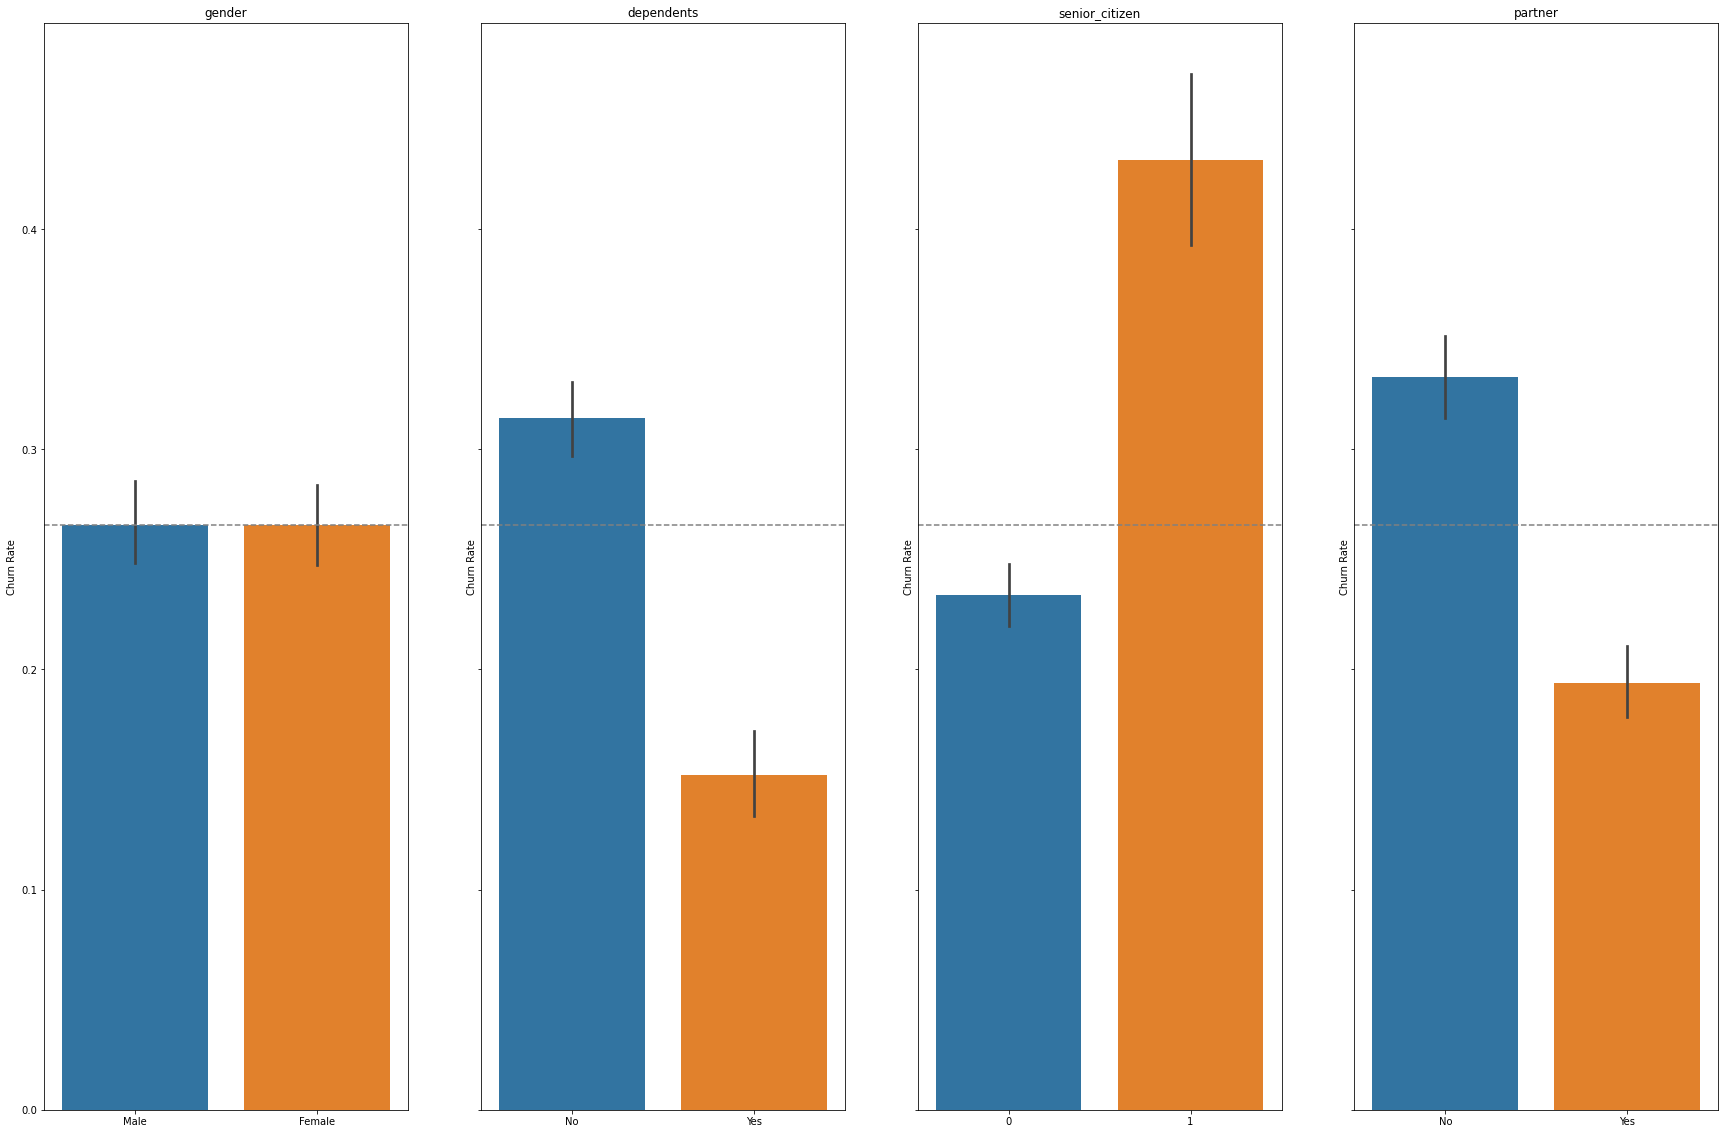

In [23]:
traits = ['gender', 'dependents', 'senior_citizen' , 'partner']
_, ax =plt.subplots(nrows = 1, ncols = 4, figsize = (30, 20), sharey = True)
for i , trait in enumerate(traits):
    sns.barplot(trait, 'churn_Yes', data = train, ax = ax[i])
    ax[i].set_xlabel('')
    ax[i].set_ylabel('Churn Rate')
    ax[i].set_title(trait)
    ax[i].axhline(churn_rate, ls='--', color = 'grey')

# add markdown questions and statistical tests to visualizations

# Takeaways:
### - seniors tend to churn more, gender has no real influence on churn, customers with dependents seem to churn less, customers without partners churn more

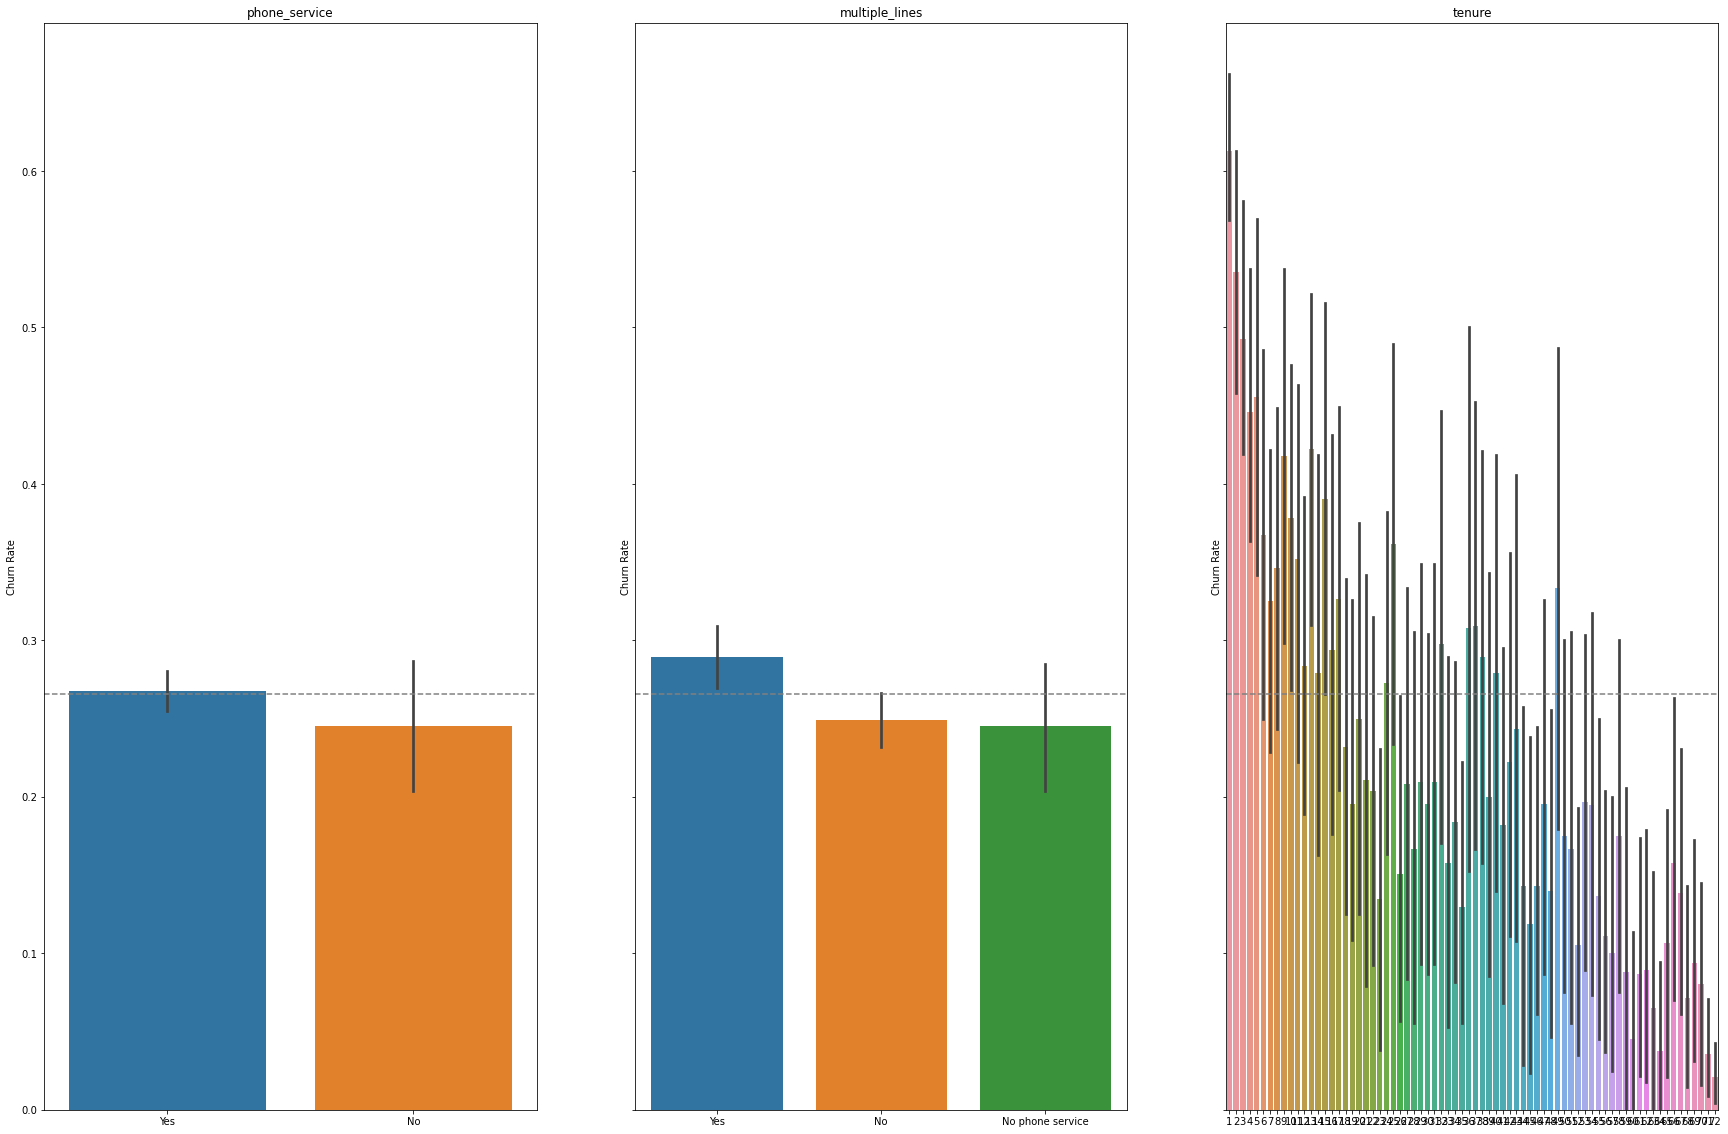

In [24]:
traits = ['phone_service', 'multiple_lines', 'tenure']
_, ax =plt.subplots(nrows = 1, ncols = 3, figsize = (30, 20), sharey = True)
for i , trait in enumerate(traits):
    sns.barplot(trait, 'churn_Yes', data = train, ax = ax[i])
    ax[i].set_xlabel('')
    ax[i].set_ylabel('Churn Rate')
    ax[i].set_title(trait)
    ax[i].axhline(churn_rate, ls='--', color = 'grey')

# Takeaways
- not a huge difference in phone service churn
- multiple lines does not seem to have influence 

### -need to bin tenure to make the data easier to read to try to get a better feel on how it drives churn

In [25]:
df.dtypes

gender                                    object
senior_citizen                             int64
partner                                   object
dependents                                object
tenure                                     int64
phone_service                             object
multiple_lines                            object
online_security                           object
online_backup                             object
device_protection                         object
tech_support                              object
streaming_tv                              object
streaming_movies                          object
paperless_billing                         object
monthly_charges                          float64
total_charges                            float64
churn                                     object
contract_type                             object
internet_service_type                     object
payment_type                              object
gender_Male         

In [26]:
order_list = train.tenure_binned.unique()
order_list

array(['16 - 20', '26 - 30', '71+', '61 - 65', '56 - 60', '46 - 50',
       '1 - 5', '21 - 25', '66 - 70', '31 - 35', '11 - 15', '51 - 55',
       '6 - 10', '41 - 45', '36 - 40'], dtype=object)

In [27]:
order_list = sorted(order_list) 
order_list

['1 - 5',
 '11 - 15',
 '16 - 20',
 '21 - 25',
 '26 - 30',
 '31 - 35',
 '36 - 40',
 '41 - 45',
 '46 - 50',
 '51 - 55',
 '56 - 60',
 '6 - 10',
 '61 - 65',
 '66 - 70',
 '71+']

In [28]:
order_list = [
    '1 - 5',
               '6 - 10',
 '11 - 15',
 '16 - 20',
 '21 - 25',
 '26 - 30',
 '31 - 35',
 '36 - 40',
 '41 - 45',
 '46 - 50',
 '51 - 55',
 '56 - 60',
 '61 - 65',
 '66 - 70',
 '71+']

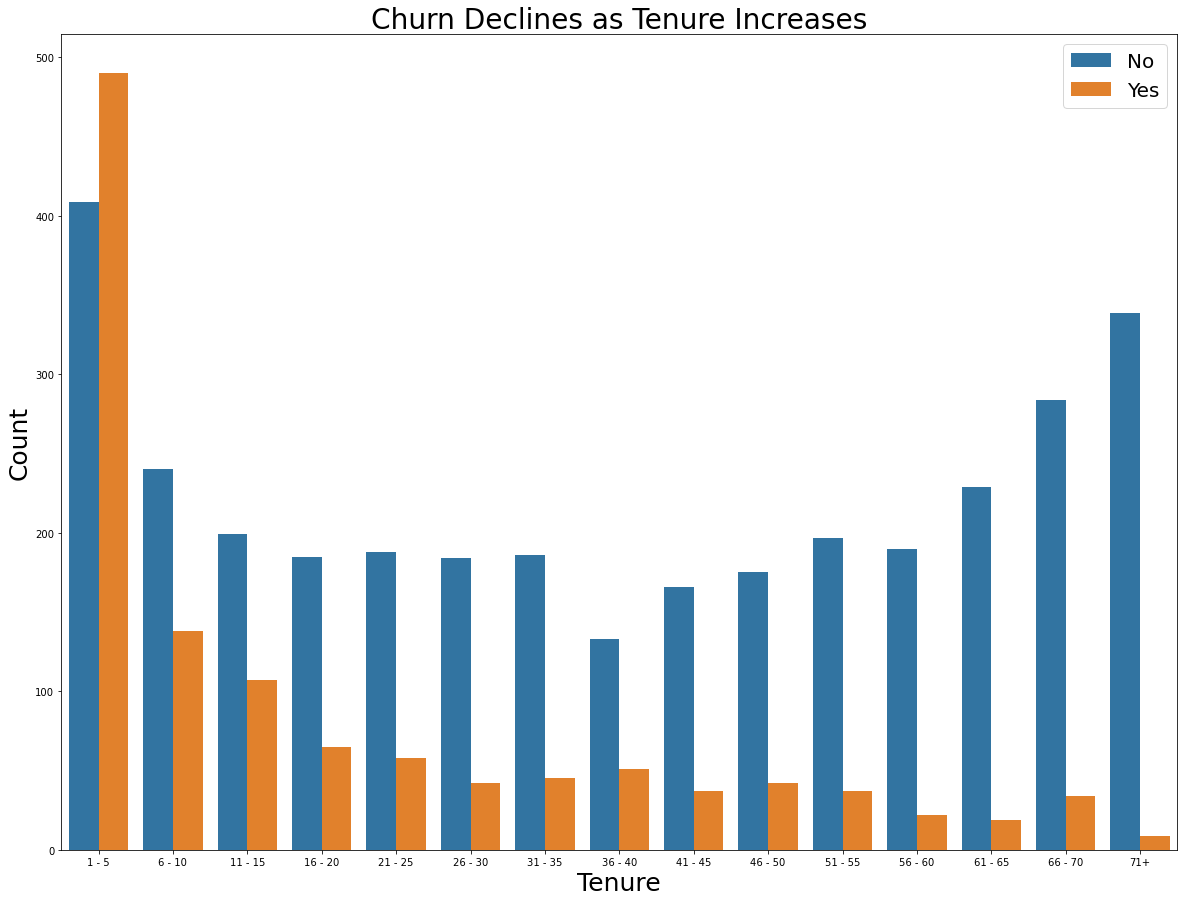

In [29]:
plt.figure(figsize = (20,15))
ax=sns.countplot(x = "tenure_binned", hue = "churn", data = train , order = order_list)
ax.set_title("Churn Declines as Tenure Increases", fontsize = 28)
plt.xlabel("Tenure",fontsize=25)
plt.ylabel("Count", fontsize=25)
plt.legend(loc="upper right", frameon=True, fontsize=20)

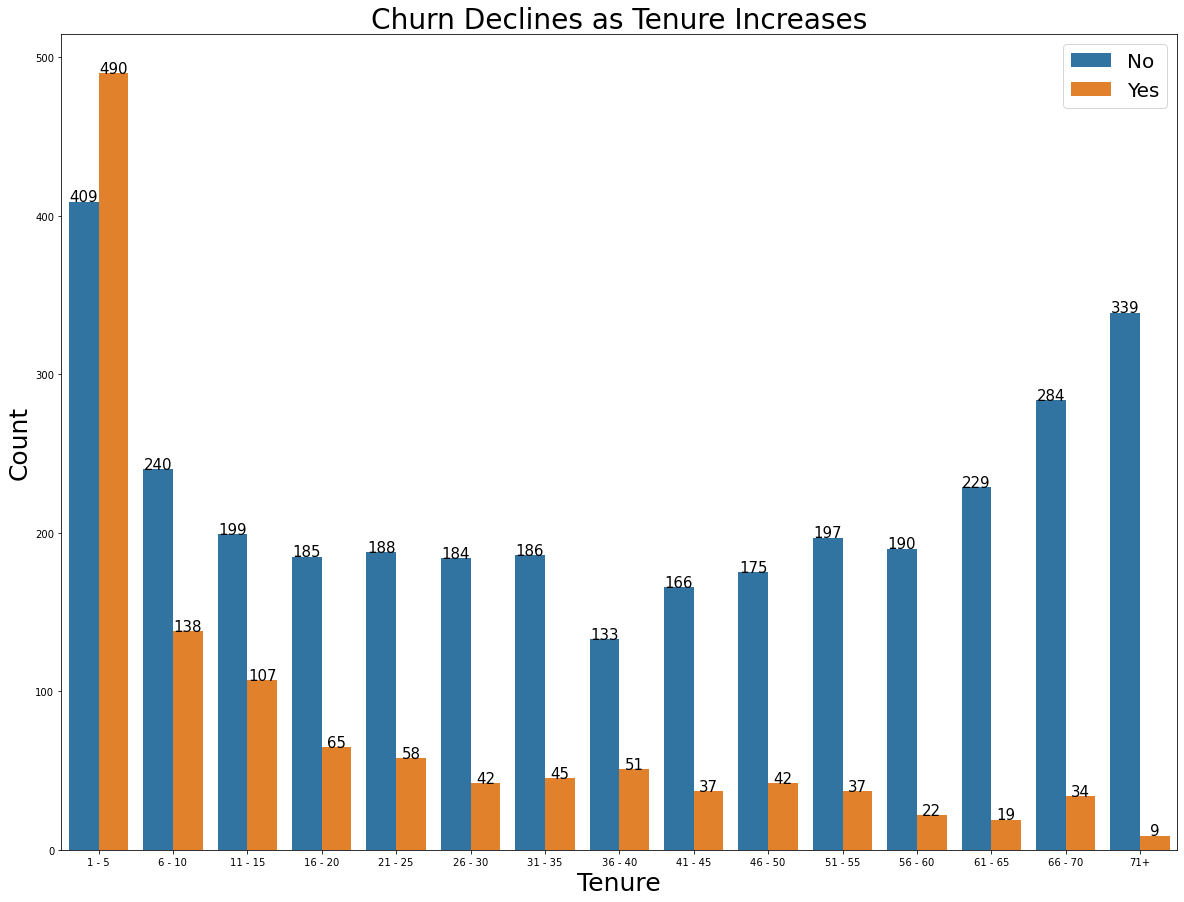

In [30]:

plt.figure(figsize = (20,15))
ax=sns.countplot(x = "tenure_binned", hue = "churn", data = train , order = order_list)
ax.set_title("Churn Declines as Tenure Increases", fontsize = 28)
plt.xlabel("Tenure",fontsize=25)
plt.ylabel("Count", fontsize=25)
plt.legend(loc="upper right", frameon=True, fontsize=20)
for p in ax.patches:
    ax.annotate(f'\n{p.get_height()}', (p.get_x()+0.2, p.get_height()), color='black', size=15, ha="center")

## here we have the count. what we really want is churn PERCENTAGE by groups of months so that we can get a clearer picture

In [31]:
tb_perc = train.groupby(['tenure_binned'])
tb_perc = round(tb_perc.mean().churn_Yes*100,2)
tb_perc

tenure_binned
1 - 5      54.51
11 - 15    34.97
16 - 20    26.00
21 - 25    23.58
26 - 30    18.58
31 - 35    19.48
36 - 40    27.72
41 - 45    18.23
46 - 50    19.35
51 - 55    15.81
56 - 60    10.38
6 - 10     36.51
61 - 65     7.66
66 - 70    10.69
71+         2.59
Name: churn_Yes, dtype: float64

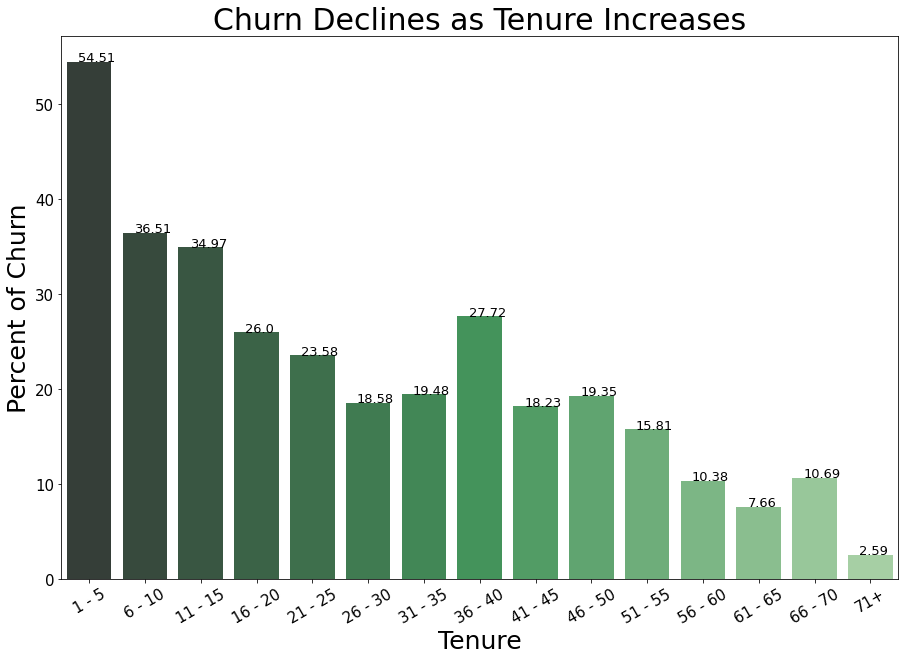

In [32]:
plt.figure(figsize = (15,10))
pal = sns.color_palette("Greens_d", len(tb_perc))
ax = sns.barplot(y= tb_perc , x = tb_perc.index, order = order_list, palette = np.array(pal[::-1]))
ax.set_xticklabels(ax.get_xticklabels(),rotation = 30)
ax.set_title("Churn Declines as Tenure Increases", fontsize = 30)
plt.xlabel("Tenure",fontsize=25)
plt.ylabel("Percent of Churn", fontsize=25)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)

for p in ax.patches:
    ax.annotate(f'\n{p.get_height()}', (p.get_x()+0.2, p.get_height()), color='black', size=13, ha="left")

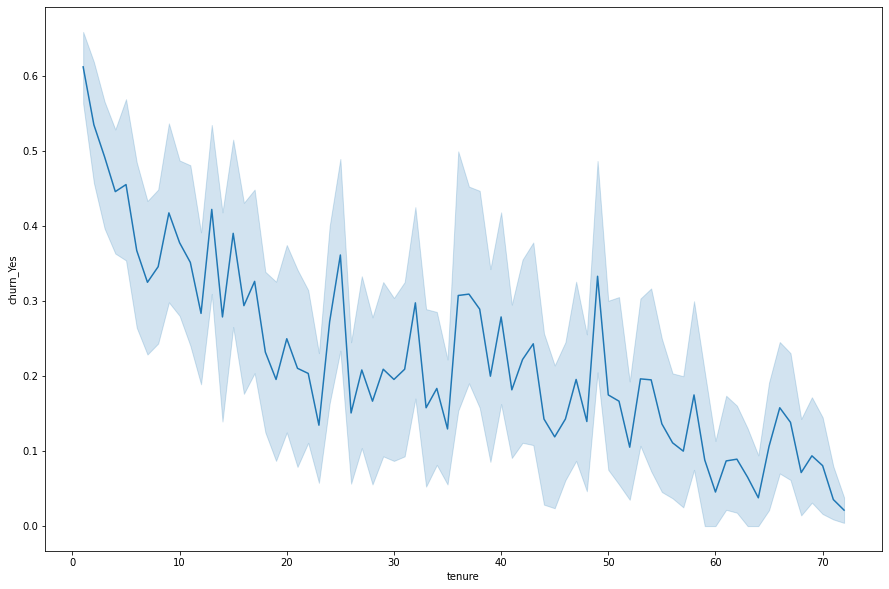

In [33]:
plt.figure('figure', figsize = (15,10))
ax = sns.lineplot(x = 'tenure' , y = "churn_Yes", data = train)

## takeaways 
### - percentage of churn seems to decrease as tenure increases

# come back to churn percentages to plot them in barplot

# gets charts for categorical columns
plt.figure(figsize=(15,45))
count = 0
for i in train.columns:
    if i == 'churn': continue
    else:
        count += 1
        plt.subplot(8,2,count)
        ax = sns.histplot(data=train,x=i,hue='churn', multiple = 'dodge')
        #display values
        for container in ax.containers:
            ax.bar_label(container)
        plt.title(i)
    
plt.tight_layout()

<AxesSubplot:xlabel='internet_service_type', ylabel='Count'>

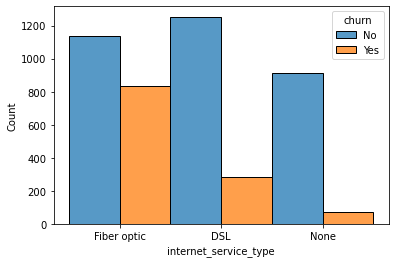

In [34]:
sns.histplot(data=train,x='internet_service_type',hue='churn', multiple = 'dodge')


In [35]:
lost = train[train.churn == "Yes"]
kept = train[train.churn == "No"]

### look at churn by payment types

In [36]:
train.groupby('churn').internet_service_type.value_counts()

churn  internet_service_type
No     DSL                      1254
       Fiber optic              1135
       None                      915
Yes    Fiber optic               837
       DSL                       286
       None                       73
Name: internet_service_type, dtype: int64

### takeaway: it seems like a large number of people that payed by electronic check have churned

In [37]:
train.groupby('churn').payment_type.value_counts()

churn  payment_type             
No     Mailed check                 839
       Credit card (automatic)      838
       Electronic check             822
       Bank transfer (automatic)    805
Yes    Electronic check             672
       Mailed check                 196
       Bank transfer (automatic)    165
       Credit card (automatic)      163
Name: payment_type, dtype: int64

In [38]:
internet_perc = train.groupby(['internet_service_type'])
internet_perc = round(internet_perc.mean().churn_Yes*100,2)
internet_perc

internet_service_type
DSL            18.57
Fiber optic    42.44
None            7.39
Name: churn_Yes, dtype: float64

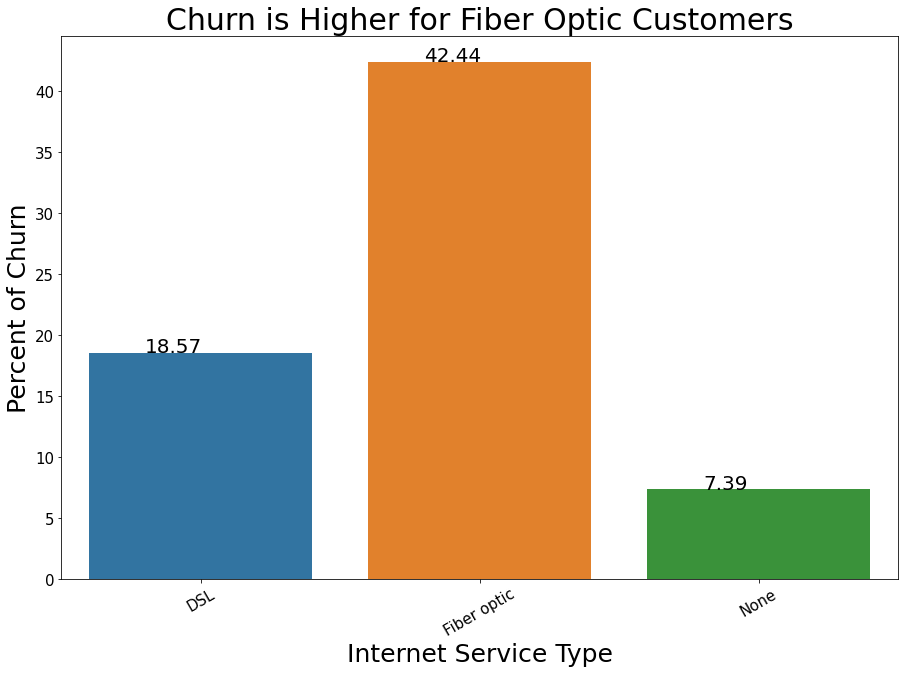

In [39]:
plt.figure(figsize = (15,10))
ax = sns.barplot(y= internet_perc , x = internet_perc.index)
ax.set_xticklabels(ax.get_xticklabels(),rotation = 30)
ax.set_title("Churn is Higher for Fiber Optic Customers", fontsize = 30)
plt.xlabel("Internet Service Type",fontsize=25)
plt.ylabel("Percent of Churn", fontsize=25)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
for p in ax.patches:
    ax.annotate(f'\n{p.get_height()}', (p.get_x()+0.2, p.get_height()), color='black', size=20, ha="left")

In [40]:
payment_perc = train.groupby(['payment_type'])
payment_perc = round(payment_perc.mean().churn_Yes*100,2)
payment_perc

payment_type
Bank transfer (automatic)    17.01
Credit card (automatic)      16.28
Electronic check             44.98
Mailed check                 18.94
Name: churn_Yes, dtype: float64

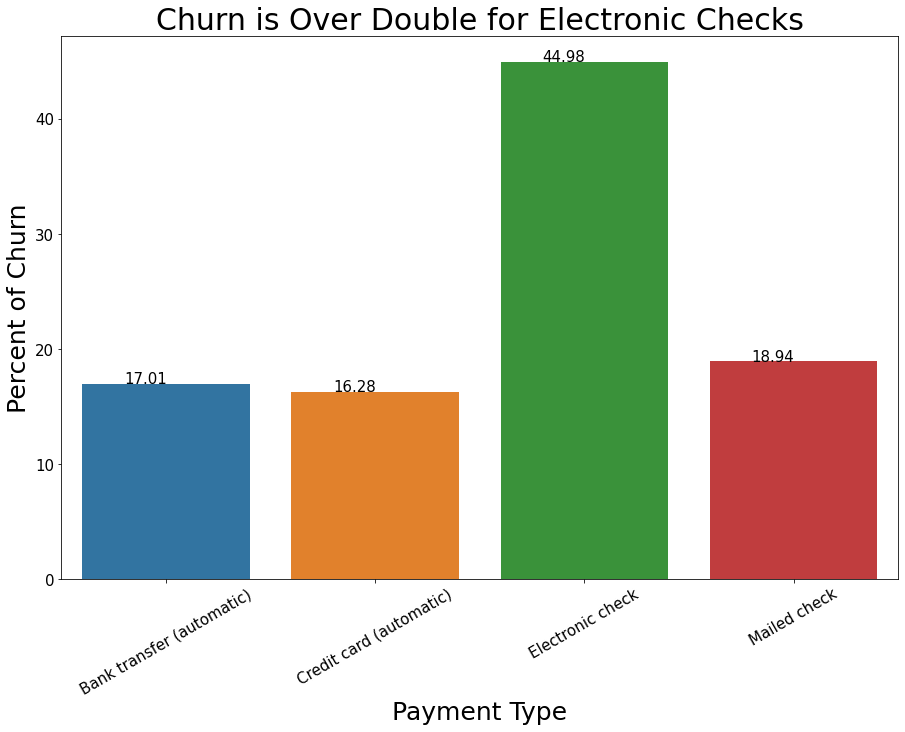

In [41]:
plt.figure(figsize = (15,10))
ax = sns.barplot(y= payment_perc , x = payment_perc.index)
ax.set_xticklabels(ax.get_xticklabels(),rotation = 30)
ax.set_title("Churn is Over Double for Electronic Checks", fontsize = 30)
plt.xlabel("Payment Type",fontsize=25)
plt.ylabel("Percent of Churn", fontsize=25)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
for p in ax.patches:
    ax.annotate(f'\n{p.get_height()}', (p.get_x()+0.2, p.get_height()), color='black', size=15, ha="left")

# Modeling

In [43]:
df2 = df.select_dtypes(exclude=['object']) 
df2.head()

,senior_citizen,tenure,monthly_charges,total_charges,gender_Male,partner_Yes,dependents_Yes,phone_service_Yes,paperless_billing_Yes,churn_Yes,...,streaming_tv_Yes,streaming_movies_No internet service,streaming_movies_Yes,contract_type_One year,contract_type_Two year,internet_service_type_Fiber optic,internet_service_type_None,payment_type_Credit card (automatic),payment_type_Electronic check,payment_type_Mailed check
0,0,9,65.6,593.30,0,1,1,1,1,0,...,1,0,0,1,0,0,0,0,0,1
1,0,9,59.9,542.40,1,0,0,1,0,0,...,0,0,1,0,0,0,0,0,0,1
2,0,4,73.9,280.85,1,0,0,1,1,1,...,0,0,0,0,0,1,0,0,1,0
3,1,13,98.0,1237.85,1,1,0,1,1,1,...,1,0,1,0,0,1,0,0,1,0
4,1,3,83.9,267.40,0,1,0,1,1,1,...,1,0,0,0,0,1,0,0,0,1


In [44]:
df2 = df2.rename(columns={'churn_Yes': 'churn'})

In [45]:
train_validate, test = train_test_split(df2, test_size= .2, 
                                                    random_state= 123, 
                                                    stratify=df2.churn)
train, validate = train_test_split(train_validate, test_size= .3, 
                                                            random_state= 123, 
                                                            stratify= train_validate.churn)

In [46]:
X_train = train.drop(columns=["churn"])
y_train = train.churn

X_validate = validate.drop(columns=["churn"])
y_validate = validate.churn

X_test = test.drop(columns=["churn"])
y_test = test.churn

In [47]:
df2.dtypes

senior_citizen                             int64
tenure                                     int64
monthly_charges                          float64
total_charges                            float64
gender_Male                                uint8
partner_Yes                                uint8
dependents_Yes                             uint8
phone_service_Yes                          uint8
paperless_billing_Yes                      uint8
churn                                      uint8
multiple_lines_No phone service            uint8
multiple_lines_Yes                         uint8
online_security_No internet service        uint8
online_security_Yes                        uint8
device_protection_No internet service      uint8
device_protection_Yes                      uint8
tech_support_No internet service           uint8
tech_support_Yes                           uint8
streaming_tv_No internet service           uint8
streaming_tv_Yes                           uint8
streaming_movies_No 

In [48]:
clf = DecisionTreeClassifier(max_depth=2, random_state=123)
# model.fit(X, y)



In [49]:
# model.fit(X, y)

clf = clf.fit(X_train, y_train)


[Text(1395.0, 1132.5, 'tenure <= 15.5\ngini = 0.39\nsamples = 3937\nvalue = [2891, 1046]'),
 Text(697.5, 679.5, 'internet_service_type_Fiber optic <= 0.5\ngini = 0.498\nsamples = 1371\nvalue = [733, 638]'),
 Text(348.75, 226.5, 'gini = 0.416\nsamples = 804\nvalue = [567, 237]'),
 Text(1046.25, 226.5, 'gini = 0.414\nsamples = 567\nvalue = [166, 401]'),
 Text(2092.5, 679.5, 'internet_service_type_Fiber optic <= 0.5\ngini = 0.267\nsamples = 2566\nvalue = [2158, 408]'),
 Text(1743.75, 226.5, 'gini = 0.099\nsamples = 1411\nvalue = [1337, 74]'),
 Text(2441.25, 226.5, 'gini = 0.411\nsamples = 1155\nvalue = [821, 334]')]

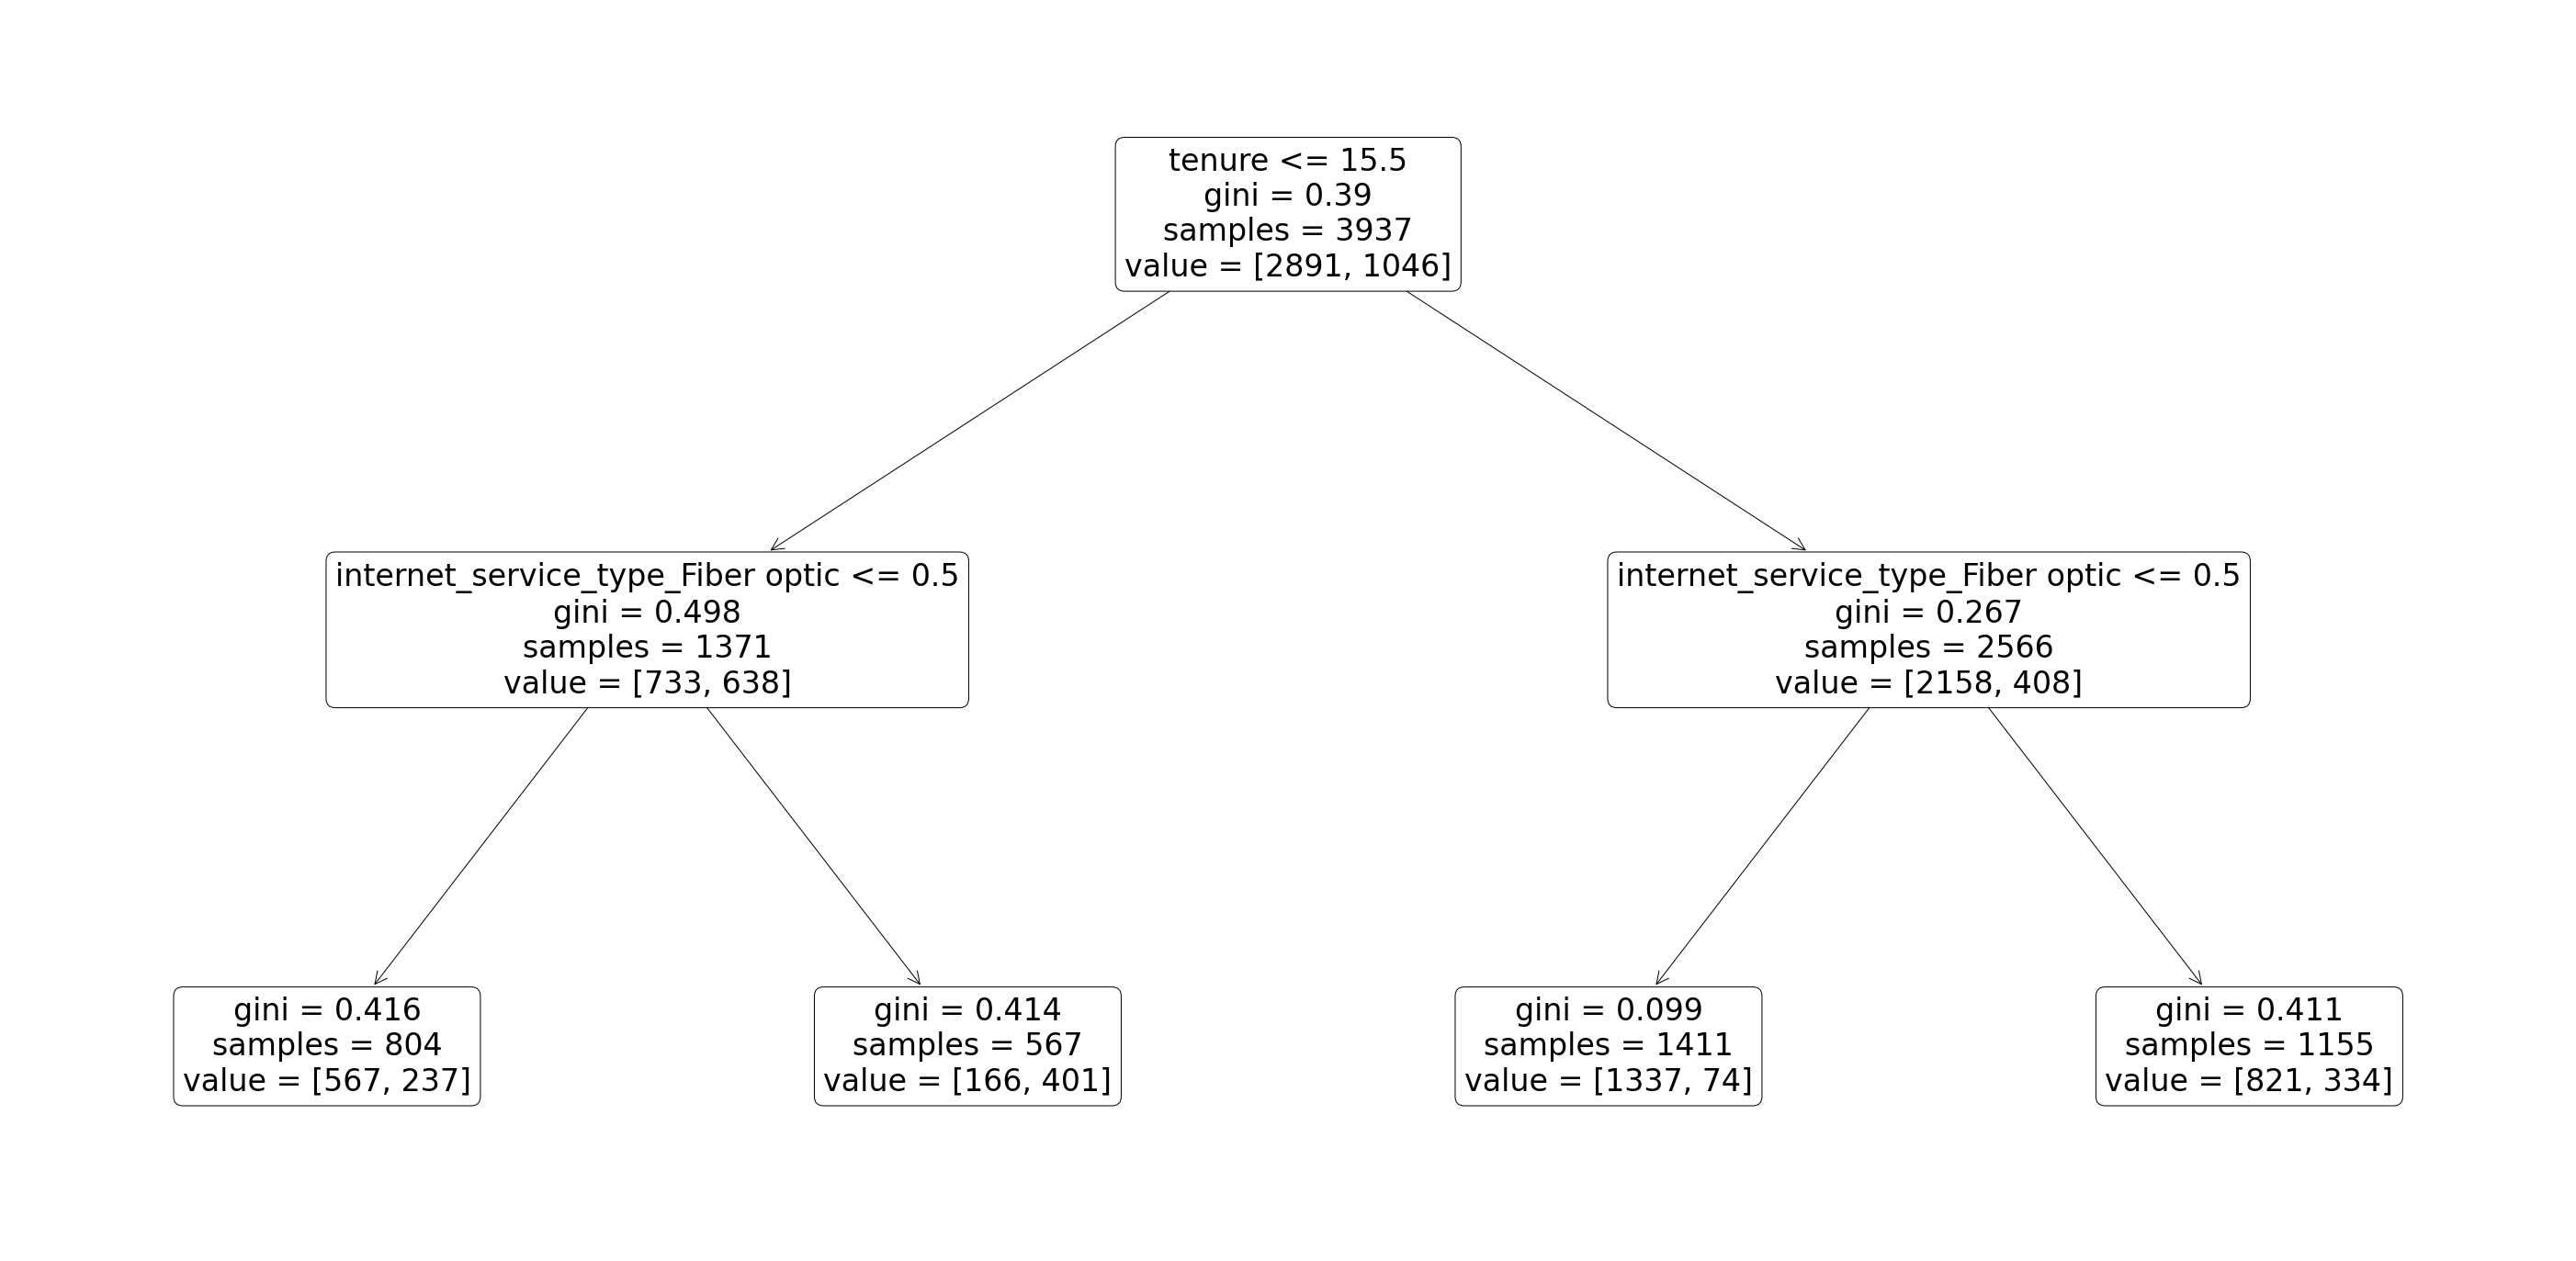

In [50]:
plt.figure(figsize=(50, 25))
plot_tree(clf, feature_names=X_train.columns, rounded=True)

In [51]:
for i in range(2, 21):
    tree = DecisionTreeClassifier(max_depth=i, random_state=123)
    tree = tree.fit(X_train, y_train)
    y_predictions = tree.predict(X_train)

    report = classification_report(y_train, y_predictions, output_dict=True)
    print(f"Tree with max depth of {i}")
    print(pd.DataFrame(report))
    print()

Tree with max depth of 2
                     0            1  accuracy    macro avg  weighted avg
precision     0.808605     0.707231  0.794006     0.757918      0.781672
recall        0.942580     0.383365  0.794006     0.662973      0.794006
f1-score      0.870468     0.497210  0.794006     0.683839      0.771299
support    2891.000000  1046.000000  0.794006  3937.000000   3937.000000

Tree with max depth of 3
                     0            1  accuracy    macro avg  weighted avg
precision     0.808605     0.707231  0.794006     0.757918      0.781672
recall        0.942580     0.383365  0.794006     0.662973      0.794006
f1-score      0.870468     0.497210  0.794006     0.683839      0.771299
support    2891.000000  1046.000000  0.794006  3937.000000   3937.000000

Tree with max depth of 4
                     0            1  accuracy    macro avg  weighted avg
precision     0.824399     0.688857   0.80061     0.756628      0.788388
recall        0.925631     0.455067   0.80061  

In [52]:
metrics = []

for i in range(2, 25):

    tree = DecisionTreeClassifier(max_depth=i, random_state=123)


    tree = tree.fit(X_train, y_train)


    in_sample_accuracy = tree.score(X_train, y_train)
    
    out_of_sample_accuracy = tree.score(X_validate, y_validate)

    output = {
        "max_depth": i,
        "train_accuracy": in_sample_accuracy,
        "validate_accuracy": out_of_sample_accuracy
    }
    
    metrics.append(output)
    
df = pd.DataFrame(metrics)
df["difference"] = df.train_accuracy - df.validate_accuracy
df

,max_depth,train_accuracy,validate_accuracy,difference
0,2,0.794006,0.776066,0.017939
1,3,0.794006,0.776066,0.017939
2,4,0.800610,0.777844,0.022766
3,5,0.806960,0.776066,0.030893
4,6,0.817374,0.779621,0.037753
5,7,0.832868,0.762441,0.070427
6,8,0.843282,0.765995,0.077286
7,9,0.860046,0.764810,0.095235
8,10,0.879350,0.757109,0.122241
9,11,0.898400,0.738744,0.159656


The optimal max_depth is 25
The accuracy on the train data at this depth is 0.998


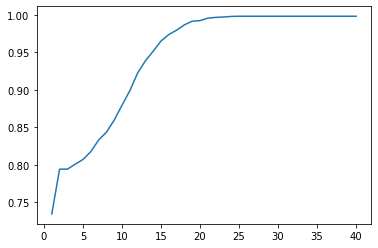

In [53]:
scores = []
for i in range(1, 41):
    tree = DecisionTreeClassifier(random_state = 1, max_depth = i)
    tree.fit(X_train, y_train)
    scores.append(tree.score(X_train, y_train))
max_train_accuracy = max(scores)
max_train_index = scores.index(max_train_accuracy)
optimal_train_depth = max_train_index + 1
print(f'The optimal max_depth is {optimal_train_depth}')
print(f'The accuracy on the train data at this depth is {round(max_train_accuracy, 3)}')

plt.plot(range(1,41), scores)
plt.show()

In [57]:
streaming_perc = train.groupby(['streaming_tv_Yes'])
streaming_perc = round(streaming_perc.mean().churn*100,2)
streaming_perc

streaming_tv_Yes
0    25.21
1    28.73
Name: churn, dtype: float64

In [55]:
tree = DecisionTreeClassifier(random_state = 1, max_depth = optimal_train_depth)
tree.fit(X_train, y_train)
y_pred2 = tree.predict(X_train)
y_pred2_proba = tree.predict_proba(X_train)

In [ ]:
confusion_matrix(y_train, y_pred2)


In [ ]:
TP= 1038
FN = 27
FP = 0 
TN = 2891


## i want a max depth of 4

# random forest

In [ ]:
rf5 = RandomForestClassifier(bootstrap=True, 
                            class_weight=None, 
                            criterion='gini',
                            min_samples_leaf=3,
                            n_estimators=300,
                            max_depth=5, 
                            random_state=123)


In [ ]:
rf5.fit(X_train, y_train)


In [ ]:
y_pred = rf5.predict(X_train)

In [ ]:
print(rf5.feature_importances_)
print(X_train.columns)

In [ ]:
y_pred_proba = rf5.predict_proba(X_train)


In [ ]:
print('Accuracy of random forest classifier on training set: {:.2f}'
     .format(rf5.score(X_train, y_train)))


In [ ]:
df2.dtypes

In [ ]:
rf10 = RandomForestClassifier(bootstrap=True, 
                            class_weight=None, 
                            criterion='gini',
                            min_samples_leaf=3,
                            n_estimators=150,
                            max_depth=10, 
                            random_state=123)

In [ ]:
rf10.fit(X_train, y_train)

In [ ]:
y_pred = rf10.predict(X_train)

In [ ]:
print(rf10.feature_importances_)


In [ ]:
y_pred_proba = rf10.predict_proba(X_train)

In [ ]:
print('Accuracy of random forest classifier on training set: {:.2f}'
     .format(rf10.score(X_train, y_train)))

In [ ]:
print(classification_report(y_train , y_pred))

### rf 15 

In [ ]:
rf15 = RandomForestClassifier(bootstrap=True, 
                            class_weight=None, 
                            criterion='gini',
                            min_samples_leaf=15,
                            n_estimators=150,
                            max_depth=10, 
                            random_state=123)

In [ ]:
rf15.fit(X_train, y_train)

In [ ]:
y_pred = rf15.predict(X_train)

In [ ]:
print(rf15.feature_importances_)

In [ ]:
y_pred_proba = rf15.predict_proba(X_train)

In [ ]:
print('Accuracy of random forest classifier on training set: {:.2f}'
     .format(rf15.score(X_train, y_train)))

In [ ]:
print(classification_report(y_train , y_pred))

### based off my eda assumptions, tenure still appears to be one of the most significant features as does fiber optic internet, but electronic check doesn't hold as much weight as expected

In [ ]:
pd.crosstab(y_train, y_pred)


In [ ]:
print(classification_report(y_train, y_pred))


In [ ]:
print('Accuracy of random forest classifier on test set: {:.2f}'
     .format(rf15.score(X_validate, y_validate)))


# KNN 

In [ ]:
# weights = ['uniform', 'density']
knn3 = KNeighborsClassifier(n_neighbors=3, weights='uniform')


In [ ]:
knn3.fit(X_train, y_train)


In [ ]:
y_pred = knn3.predict(X_train)
y_pred_proba = knn3.predict_proba(X_train)

In [ ]:
print('Accuracy of KNN classifier on training set: {:.2f}'
     .format(knn3.score(X_train, y_train)))


In [ ]:
pd.crosstab(y_train, y_pred)

In [ ]:
print(classification_report(y_train, y_pred))

In [ ]:
print('Accuracy of Decision Tree classifier on training set: {:.2f}'
     .format(knn3.score(X_train, y_train)))

print('F1 score of Decision Tree classifier on training set: {:.2f}'
     .format(f1_score(y_train, y_pred)))

recall_knn = 688/(688+358)

print('Recall of Decision Tree classifier on training set: {:.2f}'
     .format(recall_knn))


### The knn has a really poor recall/ f1 score for predicting churn

neighbor distance 3, 5

In [ ]:
knn5 = KNeighborsClassifier(n_neighbors=5, weights='uniform')

In [ ]:
knn5.fit(X_train, y_train)

In [ ]:
y_pred5 = knn5.predict(X_train)
y_pred_proba5 = knn5.predict_proba(X_train)

In [ ]:
print('Accuracy of KNN classifier on training set: {:.2f}'
     .format(knn5.score(X_train, y_train)))


In [ ]:
pd.crosstab(y_train, y_pred)

In [ ]:
print(classification_report(y_train, y_pred))